In [72]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [73]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True,
                           transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                    (0.2470, 0.2435, 0.2616))
                           ]))

Files already downloaded and verified


In [74]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
)

Files already downloaded and verified


In [75]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [76]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [77]:
# 计算connected_model中所有需要梯度更新的参数的元素数量，并返回总元素数量以及每个参数的元素数量列表
"""  
首先创建了一个列表numel_list，通过列表推导式遍历connected_model的所有参数p，
并使用p.numel()获取每个参数的元素数量。
然后，使用条件语句if p.requires_grad == True筛选出需要梯度更新的参数。
最后，使用sum()函数计算numel_list中所有元素的总和，并返回总元素数量以及numel_list列表。
"""
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [78]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [79]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [80]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

torch.nn 模块提供一维、二维、三维的卷积，其中 nn.Conv1d 用于时间序列， nn.Conv2d 用于图像， nn.Conv3d 用于体数据和视频。

In [81]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv, conv.weight.shape, conv.bias.shape

(Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)),
 torch.Size([16, 3, 3, 3]),
 torch.Size([16]))

如果我们想用一个输入图像调用 conv 模块，我们需要通过 unsqueeze()添加第 0 批处理维度，因为 nn.Conv2d()期望输入一个 B×C×H×W 的张量：

In [82]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

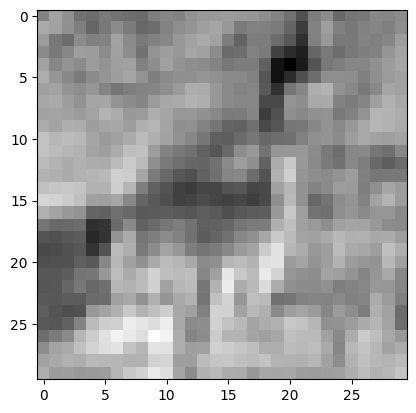

In [83]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

当 kernel_size=3 时指定 padding=1 意味着在 $i_{00}$ 位置的上面和左边有一组额外的领域，这样即使在原始图像的角落也可以计算出卷积的输出。最终的结果是，输出图像与输入图像的大小完全相同：

In [84]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

填充卷积主要有 2 个原因。首先，这样做可以帮助我们分离卷积和改变图像大小，这样我们就少了一件要记住的事情。其次，当我们有更复杂的结构，例如将在 8.5.3 小节中讨论的跳跃连接或我们将在第 2 部分中讨论的 U-Net 时，我们希望在卷积之前和之后，张量的大小是一致的，这样我们就可以将它们相加或者取差值。

我们之前说过权重和偏置是通过反向传播学习的参数，正如 nn.Linear 中的权重和偏置一样。然而，我们可以通过手动设置权重来处理卷积，看看会发生什么。

为了消除所有干扰因素，让我们首先将偏置归零，然后将权重设置为一个常数值，这样输出中的每个像素都能得到其相邻像素的均值。对每个 3×3 的邻域：

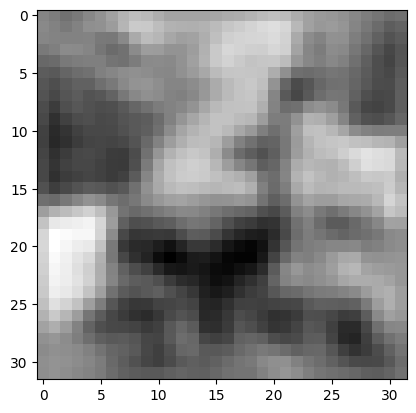

In [85]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

过滤器会产生模糊的图像，毕竟，输出的每个像素都是输入邻域的平均值，因此输出中的像素都是相关的，并且变化更加平滑。

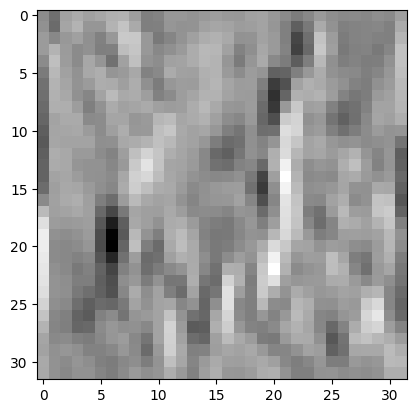

In [86]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

最大池化由 nn.MaxPool2d 模块提供，与卷积一样，其也有一维和三维数据的版本。它将池化操作的邻域的大小作为输入。如果我们想把图像缩小一半，我们让核大小为 2。让我们验证一下它在我们的输入图像上是否按预期工作：

In [87]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [88]:
# 整合模型
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(), 
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(), 
    nn.MaxPool2d(2),
    # ...
)

第 1 个卷积将我们从 3 个 RGB 通道带到 16 个 RGB 通道，因此给网络一个机会来生成 16个独立的特征，以（希望）区分鸟和飞机的低级特征。然后应用 Tanh 活化函数。得到的有 16个通道的、 32×32 的图像被第 1 个 MaxPool2d 池化成有 16 个通道的、 16×16 的图像。在这一点上，下采样图像进行另一个卷积，产生一个有 8 个通道的、 16×16 的输出。如果幸运的话，这个输出将包含更高级的特性。同样，我们应用 Tanh 激活函数，然后将其池化到有 8 个通道的、8×8 的输出。

当输入图像被缩减为 8×8 的特征集后，我们希望网络能够输出一些概率，我们可以将这些概率输入负对数似然中。然而，概率是一维向量中的一对数字（一个用于飞机，一个用于鸟），但这里我们仍然在处理多通道二维特征。

我们可以将有 8 个通道的、 8×8 的图像转换为一维向量，并使用一组全连接层来完成我们的网络：

In [89]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(), 
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(), 
    nn.MaxPool2d(2),
    # ... 缺了一些东西
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

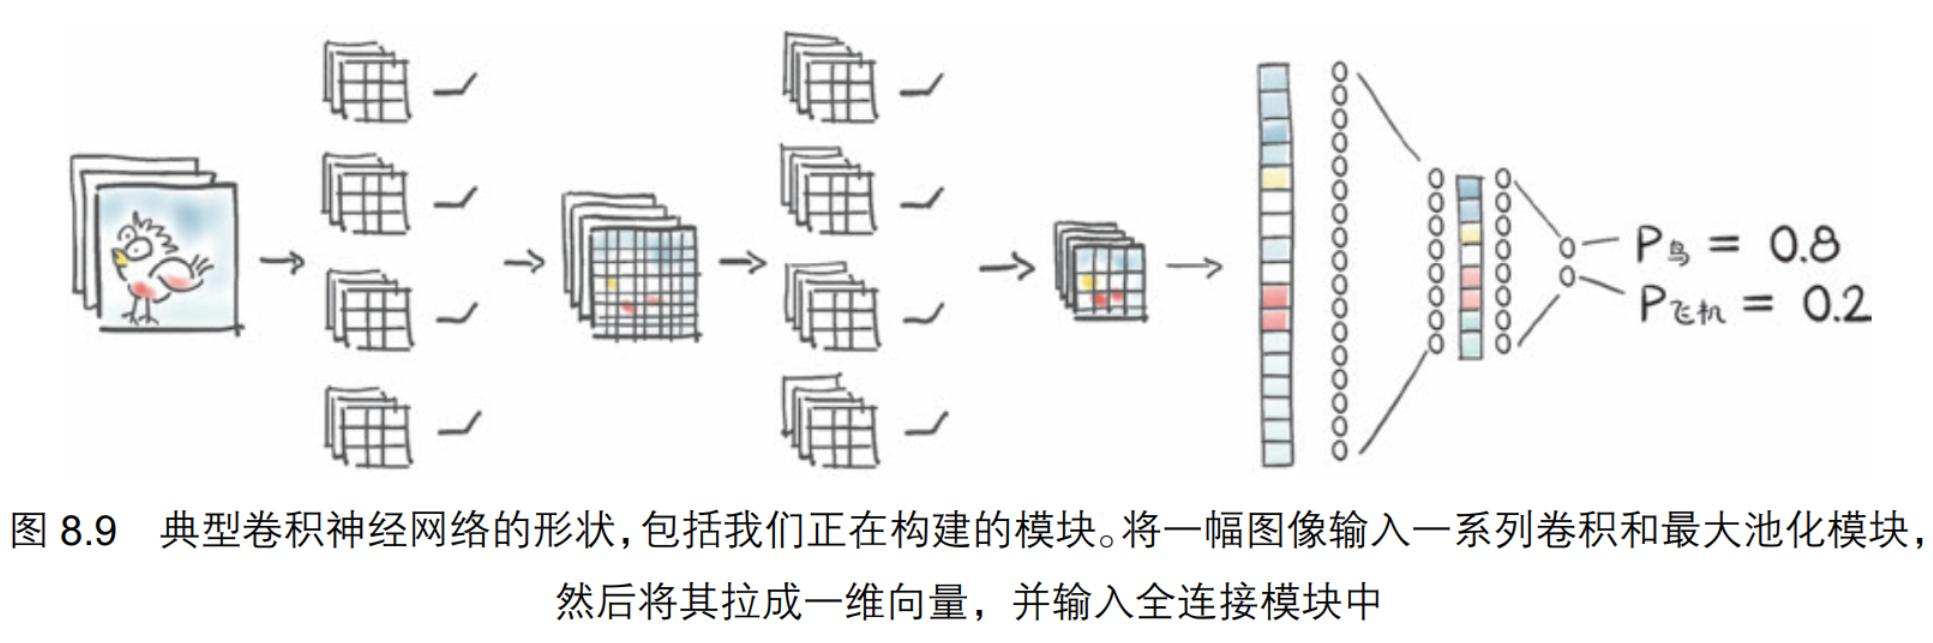

让我们首先注意，线性层的大小取决于 MaxPool2d 的预期输出大小： 8×8×8=512。让我们计算一下这个小模型的参数数目：

In [90]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

对于如此小的图像的有限数据集来说，这是非常合理的。为了增加模型的容量，我们可以增加卷积层的输出通道数量（每个卷积层产生的特征数量），这也会导致线性层大小的增加

**子类化nn.Module**

为了子类化 nn.Module，我们至少需要定义一个 forward()方法，该方法接收模块的输入并返回输出。这就是我们定义模块计算的地方。

通常情况下，运算将使用其他模块，例如内置的卷积或自定义的模块。 为了包含这些子模块，我们通常在构造函数__init__()中定义它们，并将它们分配给 self 以便在 forward()方法中使用。同时，它们将在模块的整个生命周期中保存它们的参数。

让我们把网络编写成一个子模块。为此，我们将先前在构造方法中传递给 nn.Sequential 的 nn.Conv2d、 nn.Linear 等进行初始化，然后在 forward()中一个接一个地使用它们的实例。

In [91]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # 这种重塑是我们之前所缺少的
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

基准卷积网络架构

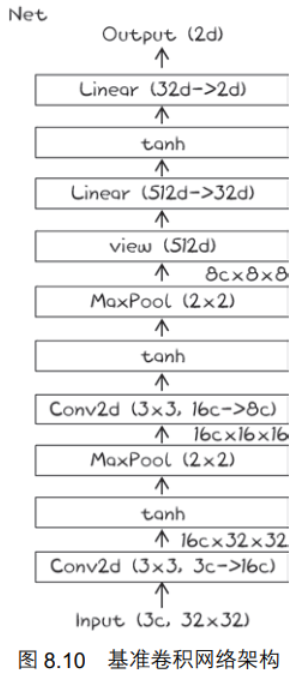

注意，我们在调用 view()时将批处理维度设置为−1，因为原则上我们不知道批次中将有多少个样本

In [92]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

这里所发生的是 parameters()调用深入构造函数中作为属性分配的所有子模块，并递归地对它们调用 parameters()方法。不管子模块如何嵌套，任何 nn.Module 都可以访问所有子模块的参数列表。通过访问子模块的 grad 属性，参数已由自动求导进行填充，优化器将知道如何更改参数以最小化损失。

In [93]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

以上代码比我们之前在 8.3.1 小节中对 Net 的定义要简洁得多，并且与之完全等同。注意，在构造函数中初始化需要几个参数的模块仍然是有意义的

让我们再次检查我们的模型是否运行，然后我们将进入训练循环：

In [94]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1772, -0.2160]], grad_fn=<AddmmBackward0>)

convnet 的核心是 2 个嵌套的循环：一个是跨迭代周期的外部循环，另一个是从数据集生成批次的 DataLoader 的内部循环。在每个循环中，我们都必须这样做：
- 通过模型提供输入（正向传播）。
- 计算损失（也是正向传播的一部分）。
- 将任何老的梯度归零。
- 调用 loss.backward()来计算损失相对所有参数的梯度（反向传播）。
- 让优化器朝着更低的损失迈进。

In [95]:
import datetime
device = (torch.device('cuda') if torch.cuda.is_available()else torch.device('cpu'))
print(f"Training on device {device}.")
# 我们的循环遍历从 1 到n_epochs，而不是从 0 开始的
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        # 在数据加载器为我们创建的批中循环数据集
        for imgs, labels in train_loader:
            # 移动到gpu上计算
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            # 通过我们的模型提供一个批次
            outputs = model(imgs)
            # 计算出我们希望最小化的损失
            loss = loss_fn(outputs, labels)
            # 去掉最后一轮的梯度
            optimizer.zero_grad()
            # 执行 backward()，也就是说，计算所有我们希望网络学习的参数的梯度
            loss.backward()
            # 更新模型
            optimizer.step()
            # 对整个循环遍历中得到的损失求和。注意：使用 item()方法将损失转换为一个数字很重要，以避免梯度变化
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'
                  .format(datetime.datetime.now(), epoch,loss_train / len(train_loader)))    

Training on device cuda.


我们使用第 7 章中的 Dataset，将其包装到 DataLoader 中，像以前一样实例化我们的网络、优化器和损失函数，并调用我们的训练循环。

In [96]:
# 数据加载器批量处理 cifar2 的样本数据集。随机打乱数据集中样本的顺序
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)
# 初始化网络（移动至gpu）
model = Net().to(device=device)
# 优化器
optimizer = optim.SGD(model.parameters(), lr=1e-2)
# 交叉熵损失
loss_fn = nn.CrossEntropyLoss()
# 开始训练
training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

2023-11-15 14:33:23.930252 Epoch 1, Training loss 0.6003845102468114
2023-11-15 14:33:26.753402 Epoch 10, Training loss 0.3233314968977764
2023-11-15 14:33:30.130501 Epoch 20, Training loss 0.29384597148864894
2023-11-15 14:33:33.315352 Epoch 30, Training loss 0.2716536579807852
2023-11-15 14:33:36.332667 Epoch 40, Training loss 0.2512547948462948
2023-11-15 14:33:39.068343 Epoch 50, Training loss 0.23392835757724798
2023-11-15 14:33:41.789958 Epoch 60, Training loss 0.21556929038588407
2023-11-15 14:33:44.587496 Epoch 70, Training loss 0.20149450065793506
2023-11-15 14:33:47.575460 Epoch 80, Training loss 0.18849769310586773
2023-11-15 14:33:50.500577 Epoch 90, Training loss 0.17507940246041415
2023-11-15 14:33:53.362617 Epoch 100, Training loss 0.1625028500558844


为了有一个比损失更易于解释的测量方法，可以看看模型在训练集和验证集上的准确度。

In [97]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)
all_acc_dict = collections.OrderedDict()
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        # 不希望更新参数，所以不需要梯度
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                # 将最大值的索引作为输出
                _, predicted = torch.max(outputs, dim=1)
                # 计算样本的数量， 因此 total 会随着批处理的大小而增加
                total += labels.shape[0]
                # 比较具有最大概率的预测类和真实值标签，我们首先得到一个布尔数组。统计这个批次中预测值和实际值一致的项的总数
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


In [98]:
validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


{'train': 0.9356, 'val': 0.8965}

我们将整数张量转换为 Python 中的 int， 这相当于使用 item()， 像我们在训练循环中所做的那样。

这比全连接模型好多了，后者的准确率只有约 79%。我们将验证集上的错误数量减少了约一半。此外，我们使用的参数也少得多。这告诉我们， 通过局部性和平移不变性，该模型在从新样本中概括识别图像主题方面做得更好。我们现在可以让它运行更多的迭代周期，看看性能如何

**保存并加载模型**

保存模型

In [99]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

现在 birds_vs_airplanes.pt 文件包含模型的所有参数： 即 2 个卷积模块和 2 个线性模块的权重和偏置。因此，模块没有结构，只有权重。这意味着，当我们为我们的朋友在生产中部署模型时，我们需要方便地保存模型类，并能够方便地创建一个实例，然后将参数加载到模型实例中：

加载模型

In [100]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

加载网络权重时有一点儿复杂： PyTorch 将尝试将权重加载到保存它的同一设备上。也就是说， GPU 上的权重将恢复到 GPU 上。 由于我们不知道是否需要相同的设备， 我们有 2 个选择：在保存之前将网络移动到 CPU，或者在恢复后将其移回。在加载权重时，指示 PyTorch 覆盖设备信息会更简洁一些。这是通过将 map_location 关键字参数传递给 torch.load 来实现的：

In [101]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

**增加内存容量：宽度**

考虑到我们的前馈架构，在进入更复杂的问题之前，我们可能需要研究几个维度。第 1 个维度是网络的宽度：每层的神经元数，或每个卷积的通道数。在 PyTorch 中我们可以很容易地使模型变宽。我们只需在第 1 个卷积中指定更多的输出通道，并相应地增加后续的层数（注意改变前向函数），以反映这样一个事实：一旦切换到全连接层，我们将得到一个更长的向量。

In [102]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32,16,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(16*8*8,32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [103]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2023-11-15 14:33:54.086791 Epoch 1, Training loss 0.5580524703499617
2023-11-15 14:33:56.572712 Epoch 10, Training loss 0.32644100885862
2023-11-15 14:33:59.354484 Epoch 20, Training loss 0.27857467095563365
2023-11-15 14:34:02.310289 Epoch 30, Training loss 0.243827733406975
2023-11-15 14:34:05.204909 Epoch 40, Training loss 0.21471882568802803
2023-11-15 14:34:08.221491 Epoch 50, Training loss 0.1884417362558614
2023-11-15 14:34:11.019610 Epoch 60, Training loss 0.16387159652580882
2023-11-15 14:34:13.817553 Epoch 70, Training loss 0.14027086479269016
2023-11-15 14:34:16.648891 Epoch 80, Training loss 0.11795444615707276
2023-11-15 14:34:19.446373 Epoch 90, Training loss 0.0977113642700159
2023-11-15 14:34:22.277820 Epoch 100, Training loss 0.0799923781661471
Accuracy train: 0.97
Accuracy val: 0.89


{'train': 0.9732, 'val': 0.8915}

如果我们想避免在模型定义中硬编码数字，我们可以很容易地将一个参数传递给__init__()并参数化宽度，同时注意在 forward()方法中参数化对 view()的调用：

In [104]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1 = 32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3,n_chans1,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(n_chans1,n_chans1 // 2,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*n_chans1//2,32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [105]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2023-11-15 14:34:22.765095 Epoch 1, Training loss 0.5550218389672079
2023-11-15 14:34:25.439247 Epoch 10, Training loss 0.32345122355184736
2023-11-15 14:34:28.335542 Epoch 20, Training loss 0.28518931017180155
2023-11-15 14:34:31.311074 Epoch 30, Training loss 0.2557785837988185
2023-11-15 14:34:34.321070 Epoch 40, Training loss 0.22648689293178023
2023-11-15 14:34:37.280545 Epoch 50, Training loss 0.19996489086158717
2023-11-15 14:34:40.185998 Epoch 60, Training loss 0.17566774125881257
2023-11-15 14:34:43.155690 Epoch 70, Training loss 0.15216365228792664
2023-11-15 14:34:46.145948 Epoch 80, Training loss 0.12945401336357093
2023-11-15 14:34:49.052225 Epoch 90, Training loss 0.1086596473102357
2023-11-15 14:34:52.029916 Epoch 100, Training loss 0.09015923083587817
Accuracy train: 0.96
Accuracy val: 0.89


In [106]:
sum(p.numel() for p in model.parameters())

38386

容量越大，模型所能管理的输入的可变性就越大。但与此同时，模型出现过拟合的可能性也越大，因为模型可以使用更多的参数来记忆输入中不重要的方面。

我们已经研究了对抗过拟合最好的方法是增加样本数量，或者在没有新数据的情况下，通过人工修改相同的数据来增加现有数据。

**正则化**

检查参数：权重惩罚

L2 正则化也称为权重衰减。叫这个名字的原因是考虑到 SGD 和反向传播， L2 正则化对参数 $w_i$ 的负梯度为$−2 * \lambda * w_i$，其中 $\lambda$ 是前面提到的超参数，在 PyTorch 中简称为权重衰减。因此，在损失函数中加入 L2 正则化，相当于在优化步骤中将每个权重按其当前值的比例递减（因此称为权重衰减）。注意，权重衰减适用于网络的所有参数，例如偏置。

In [107]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lamda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

In [108]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2023-11-15 14:34:52.739950 Epoch 1, Training loss 0.5664023853790988
2023-11-15 14:34:56.022175 Epoch 10, Training loss 0.34521505815587983
2023-11-15 14:34:59.530423 Epoch 20, Training loss 0.29931578600102926
2023-11-15 14:35:02.975644 Epoch 30, Training loss 0.27143931445802094
2023-11-15 14:35:06.610652 Epoch 40, Training loss 0.24890191340522402
2023-11-15 14:35:10.296709 Epoch 50, Training loss 0.22979941057741263
2023-11-15 14:35:14.123273 Epoch 60, Training loss 0.21303533212204648
2023-11-15 14:35:17.611759 Epoch 70, Training loss 0.19759082836899788
2023-11-15 14:35:21.153706 Epoch 80, Training loss 0.18291690494793994
2023-11-15 14:35:24.773846 Epoch 90, Training loss 0.16870703761744651
2023-11-15 14:35:28.852431 Epoch 100, Training loss 0.15500377118587494
Accuracy train: 0.92
Accuracy val: 0.88


不太依赖于单一输入： Dropout

在 PyTorch 中，我们可以通过在非线性激活与后面的线性或卷积模块之间添加一个nn.Dropout 模块在模型中实现 Dropout。作为一个参数，我们需要指定输入归零的概率。如果是卷积，我们将使用专门的 nn.Dropout2d 或者 nn.Dropout3d，将输入的所有通道归零：

In [109]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8*8*n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8*8*self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [110]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2023-11-15 14:35:29.404200 Epoch 1, Training loss 0.5919364863520216
2023-11-15 14:35:32.738892 Epoch 10, Training loss 0.37477110183922346
2023-11-15 14:35:36.445530 Epoch 20, Training loss 0.3473004407373963
2023-11-15 14:35:40.191444 Epoch 30, Training loss 0.3274606259385492
2023-11-15 14:35:43.981013 Epoch 40, Training loss 0.31153551512842725
2023-11-15 14:35:47.841430 Epoch 50, Training loss 0.2965073532359615
2023-11-15 14:35:51.184913 Epoch 60, Training loss 0.28060643327463963
2023-11-15 14:35:54.537340 Epoch 70, Training loss 0.2748887359526507
2023-11-15 14:35:57.918161 Epoch 80, Training loss 0.26144908401806644
2023-11-15 14:36:01.331166 Epoch 90, Training loss 0.2554018776507894
2023-11-15 14:36:04.569684 Epoch 100, Training loss 0.24123481295670673
Accuracy train: 0.90
Accuracy val: 0.87


注意，在训练过程中 Dropout 通常是活跃的，而在生产过程中评估一个训练模型时，会绕过Dropout，或者等效地给其分配一个等于 0 的概率。这是通过 Dropout 模块的 train 属性来控制的。

保持激活检查：批量归一化

批量归一化背后的主要思想是将输入重新调整到网络的激活状态， 从而使小批量具有一定的理想分布。回想一下学习机制和非线性激活函数的作用，这有助于避免激活函数的输入过多地进入函数的饱和部分，从而消除梯度并减慢训练速度。

实际上，批量归一化使用在该中间位置收集的小批量样本的平均值和标准差来对中间输入进行移位和缩放。正则化效应是这样一个事实的结果，即单个样本及其下游激活函数总是被模型视为平移和缩放，这取决于随机提取的小批量的统计数据，这本身就是一种原则性的增强。上述论文的作者建议，使用批量归一化消除或减轻对 Dropout 的需要。

由于批量归一化的目的是重新调整激活的输入，因此其位置是在线性变换（在本例中是卷积）和激活函数之后，如下所示：

In [111]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8*8*n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8*8*self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [112]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2023-11-15 14:36:05.135001 Epoch 1, Training loss 0.4723325517906505
2023-11-15 14:36:08.168832 Epoch 10, Training loss 0.27009856264302684
2023-11-15 14:36:11.545299 Epoch 20, Training loss 0.21250255795041467
2023-11-15 14:36:14.921810 Epoch 30, Training loss 0.16600698953980852
2023-11-15 14:36:18.335882 Epoch 40, Training loss 0.12423068192449345
2023-11-15 14:36:21.719763 Epoch 50, Training loss 0.08815479336697964
2023-11-15 14:36:25.128779 Epoch 60, Training loss 0.05923179257661104
2023-11-15 14:36:28.573511 Epoch 70, Training loss 0.03835402221484169
2023-11-15 14:36:31.956537 Epoch 80, Training loss 0.025221453700807823
2023-11-15 14:36:35.300594 Epoch 90, Training loss 0.017821590905522655
2023-11-15 14:36:38.669048 Epoch 100, Training loss 0.01128286809162207
Accuracy train: 0.99
Accuracy val: 0.87


跳跃连接只是将输入添加到层块的一个输出中，这正是 PyTorch 的做法。让我们在简单的卷积模型中添加一层，并改变激活函数（这里使用 ReLU）。带有额外层的普通模块是这样的：

In [113]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [114]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2023-11-15 14:36:39.203434 Epoch 1, Training loss 0.6931076960958493
2023-11-15 14:36:42.099798 Epoch 10, Training loss 0.3427142170584126
2023-11-15 14:36:45.275307 Epoch 20, Training loss 0.299701430045875
2023-11-15 14:36:48.483993 Epoch 30, Training loss 0.2721380820130087
2023-11-15 14:36:51.660932 Epoch 40, Training loss 0.24551472865092527
2023-11-15 14:36:54.838427 Epoch 50, Training loss 0.2196346950379147
2023-11-15 14:36:58.020114 Epoch 60, Training loss 0.19604533322297843
2023-11-15 14:37:01.222758 Epoch 70, Training loss 0.17310300327030717
2023-11-15 14:37:04.460875 Epoch 80, Training loss 0.14968778406548652
2023-11-15 14:37:07.637885 Epoch 90, Training loss 0.1259845440412403
2023-11-15 14:37:10.828635 Epoch 100, Training loss 0.10388932621498016
Accuracy train: 0.96
Accuracy val: 0.92


仿照 ResNet 向这个模型添加一个跳跃连接，相当于在 forward()方法函数中将第 1 层的输出添加到第 3 层的输入中：

In [115]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [116]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2023-11-15 14:37:11.347395 Epoch 1, Training loss 0.6012909235847983
2023-11-15 14:37:14.255562 Epoch 10, Training loss 0.3264386306522758
2023-11-15 14:37:17.480744 Epoch 20, Training loss 0.2771867570603729
2023-11-15 14:37:20.704076 Epoch 30, Training loss 0.24372732402033107
2023-11-15 14:37:23.944198 Epoch 40, Training loss 0.2132068134986671
2023-11-15 14:37:27.151512 Epoch 50, Training loss 0.18392944103403455
2023-11-15 14:37:30.359007 Epoch 60, Training loss 0.15546422980868133
2023-11-15 14:37:33.598496 Epoch 70, Training loss 0.12886687401373675
2023-11-15 14:37:36.817597 Epoch 80, Training loss 0.10339286088184187
2023-11-15 14:37:40.032553 Epoch 90, Training loss 0.08121442354646079
2023-11-15 14:37:43.288497 Epoch 100, Training loss 0.07068590119860735
Accuracy train: 0.96
Accuracy val: 0.89


我们首先创建一个模块子类，它唯一的任务是为一个块提供计算，该块包含一组卷积、激活函数和跳跃连接：

In [117]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,padding=1,bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

因为我们计划生成一个深度模型，所以我们在块中添加了批量归一化，这将有助于防止梯度在训练期间消失。

首先，在`__init__()`中，我们创建了一个包括残差块实例列表的 `nn.Sequential`。 `nn.Sequential`将确保一个块的输出被用作下一个块的输入， 它还将确保块中的所有参数对网络是可见的。 然后，在 `forward()`中，我们只需调用 `nn.Sequential` 来遍历 100 个块并生成输出。

In [118]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8*8*n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8*8*self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [119]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2023-11-15 14:37:52.360542 Epoch 1, Training loss 3.466476868292329
2023-11-15 14:39:13.506121 Epoch 10, Training loss 0.37113807905631463
2023-11-15 14:40:47.039280 Epoch 20, Training loss 0.30866580110067016
2023-11-15 14:42:19.433822 Epoch 30, Training loss 0.2526694114325912
2023-11-15 14:43:58.482354 Epoch 40, Training loss 0.20142771446021498
2023-11-15 14:45:33.747508 Epoch 50, Training loss 0.15903194961701608
2023-11-15 14:47:04.622906 Epoch 60, Training loss 0.12697360509187933
2023-11-15 14:48:38.247782 Epoch 70, Training loss 0.10630942043510212
2023-11-15 14:50:09.970148 Epoch 80, Training loss 0.08541773544375304
2023-11-15 14:51:40.488359 Epoch 90, Training loss 0.06227900809756699
2023-11-15 14:53:11.158758 Epoch 100, Training loss 0.07736275249433698
Accuracy train: 0.96
Accuracy val: 0.88


在实现过程中，我们参数化了实际层数，这对于实验和重用非常重要。此外，反向传播也将如预期的那样工作。不出所料，网络的收敛速度要慢得多。它在融合方面也更加脆弱，这就是我们使用更加详细的初始化， 并以 3e-3 的学习率训练我们的 ResNet， 而不是我们在其他网络中使用的 1e−2的原因。我们没有训练任何一个网络去融合，但如果没有这些调整，我们就不会取得任何进展。

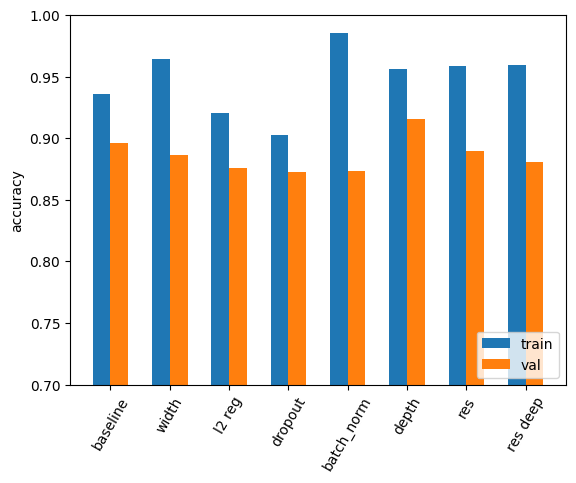

In [121]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()